<a href="https://colab.research.google.com/github/jkordonis/TropicalML/blob/main/LMPC_Tropical_Divisio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cvxpy as cp
import numpy as np
import time
import matplotlib.pyplot as plt
!pip install plotly
import plotly.graph_objects as go

In [ ]:
x0=np.random.rand(2)
x0=np.array([2,-1])

A=np.array([[0.75,.5],[0.4,0.9]])
b=np.array([0,.5])


In [ ]:
A_til=np.zeros((10,2))
b_til= np.zeros(10)

In [ ]:
def phi(x,u):
  norm_x = cp.norm(x)
  norm_u = cp.norm(u)
  return   cp.power(norm_u, 2)+norm_x + cp.power(norm_x, 3)
def Q_cost_to_go(x):
  return cp.max(A_til@x+b_til)
def Realized_Cost(x_realized,u_realized):
  return
def Q_cost_to_go_np(x):
  return np.max(A_til@x+b_til)

In [ ]:
def mpc_run(xk_0):
  x1 = cp.Variable(2)
  x2 = cp.Variable(2)
  x3 = cp.Variable(2)
  u0 = cp.Variable(1)
  u1 = cp.Variable(1)
  u2 = cp.Variable(1)
  objective = cp.Minimize(phi(xk_0,u0)+phi(x1,u1)+phi(x2,u2)+ cp.maximum(Q_cost_to_go(x3),0))
  constraints= [x1==A@xk_0+b*u0,x2==A@x1+b*u1,x3==A@x2+b*u2]
  problem = cp.Problem(objective,constraints)
  problem.solve()
  return u0.value

In [ ]:
def mpc_run_two_stage(xk_0):
  x1 = cp.Variable(2)
  x2 = cp.Variable(2)
  u0 = cp.Variable(1)
  u1 = cp.Variable(1)

  objective = cp.Minimize(phi(xk_0,u0)+phi(x1,u1)+ cp.maximum(Q_cost_to_go(x2),0))
  constraints= [x1==A@xk_0+b*u0,x2==A@x1+b*u1]
  problem = cp.Problem(objective,constraints)
  problem.solve()
  return u0.value

In [ ]:
def mpc_eval_at_x_sequence_ret_x_u(x_sample_j,T):
  x_var=np.random.rand(T,2)
  u_var=np.random.rand(T)
  x_var[0]=x_sample_j

  for i in range(T-1):
    u_var[i]=mpc_run(x_var[i])[0]
    x_var[i+1,:]=A@x_var[i,:]+b*u_var[i]
  return x_var,u_var

def mpc_eval_at_x(x_sample_j,T):
  x_var,u_var=mpc_eval_at_x_sequence_ret_x_u(x_sample_j,T)
  return np.array([phi(x_var[i],u_var[i]).value for i in range(T-1)]).sum()
def cost_computatetion_given_trajectory(x_simulated,u_simulated):
  return np.array([phi(x_simulated[i],u_simulated[i]).value for i in range(x_simulated.shape[0]-1)]).sum()


In [ ]:
x_var,u_var=mpc_eval_at_x_sequence_ret_x_u(np.array([0.5,0.3]),100)

In [ ]:
def BENCHMARK_POINTS_GRID_MPC_EVAL(Eval_Horizon):
  X_all_samples = np.random.rand(0,2)
  y_all_samples = np.random.rand(0)

  #BENCHMARK POINTS GRID
  xx,yy=np.linspace(-1,1, 10) ,np.linspace(-1, 1, 10)
  V=np.zeros((10,10))
  for ii in range(10):
    for jj in range(10):
      x_sample_j=np.array([xx[ii],yy[jj]])
      V[ii,jj]=mpc_eval_at_x(x_sample_j,Eval_Horizon)
      X_all_samples=np.append(X_all_samples,[x_sample_j],axis=0)
      y_all_samples=np.append(y_all_samples,V[ii,jj])

  return X_all_samples,y_all_samples,V

In [ ]:
def Evaluate_in_N_points(Number_of_Points,Eval_Horizon,X_all_samples,y_all_samples):
  for ii in range(Number_of_Points):
    x_sample_j_inint=np.random.randn(2)
    x_simulated,u_simulated= mpc_eval_at_x_sequence_ret_x_u(x_sample_j_inint,Eval_Horizon)
    x_sample_j = x_simulated[0:5]
    for i in range(5):
      X_all_samples=np.append(X_all_samples,[x_sample_j[i]],axis=0)
      y_all_samples=np.append(y_all_samples,cost_computatetion_given_trajectory(x_simulated[i:],u_simulated[i:]))
  return X_all_samples,y_all_samples

In [ ]:
def find_approx_q_with_Tropical_Division_random_Start(Number_of_Pieces):
  A_of_q = np.random.randn(Number_of_Pieces,2)
  b_of_q = np.random.randn(Number_of_Pieces)
  for ii in range(150):
    I=np.argmax((X_all_samples@A_of_q.T+b_of_q),axis=1)
    J_i=np.array([(I==i).sum() for i in range(Number_of_Pieces)])
    b_of_q=b_of_q-J_i*0.01
  b_of_q=b_of_q-b_of_q.mean()

  a_q_i = cp.Variable(2)
  b_q_i = cp.Variable(1)
  for epan in range(15):
    I=np.argmax((X_all_samples@A_of_q.T+b_of_q),axis=1)
    J_i=np.array([(I==i).sum() for i in range(Number_of_Pieces)])
    for i in range(Number_of_Pieces):
      if J_i[i]==0:
        A_of_q[i,:]=np.zeros(2)
        b_of_q[i]=-1
        #print("found")
        continue
      objective = cp.Maximize(cp.sum(X_all_samples[I==i]@a_q_i)+sum(I==i)*b_q_i)
      constraints= [X_all_samples[I==i]@a_q_i+b_q_i<=y_all_samples[I==i]]
      problem = cp.Problem(objective,constraints)
      problem.solve()
      A_of_q[i,:]=a_q_i.value
      b_of_q[i]=b_q_i.value
    VVV_est = np.max((X_all_samples@A_of_q.T+b_of_q),axis=1)

  return A_of_q,b_of_q,(y_all_samples-VVV_est).sum()

In [ ]:
def find_approx_q_with_Tropical_Division_multi_Start(Number_of_Pieces):
  minim_error=100000000
  for iter in range(50):
    A_til_,b_til_,dump_var=find_approx_q_with_Tropical_Division_random_Start(Number_of_Pieces)
    if dump_var<minim_error:
      minim_error=dump_var
      A_til=A_til_
      b_til=b_til_
  return A_til,b_til,minim_error

In [ ]:
X_all_samples=np.random.rand(0,2)
y_all_samples=np.ones(0)
X_all_samples,y_all_samples=Evaluate_in_N_points(10,5,X_all_samples,y_all_samples)


In [ ]:
X_all_samples=np.random.rand(0,2)
y_all_samples=np.ones(0)
A_til=np.zeros((10,2))
b_til= np.zeros(10)

for iter in range(25):
  print("[0.3,0.5]",mpc_eval_at_x(np.array([0.3,0.5]),100))
  X_all_samples,y_all_samples=Evaluate_in_N_points(10,50,X_all_samples,y_all_samples)
  if iter>0:
    for ii in range(X_all_samples.shape[0]):
      y_all_samples[ii]=np.minimum(Q_cost_to_go_np(X_all_samples[ii]),y_all_samples[ii])
  A_til,b_til,err=find_approx_q_with_Tropical_Division_multi_Start(4)


print(mpc_eval_at_x(np.array([0.3,0.5]),100))


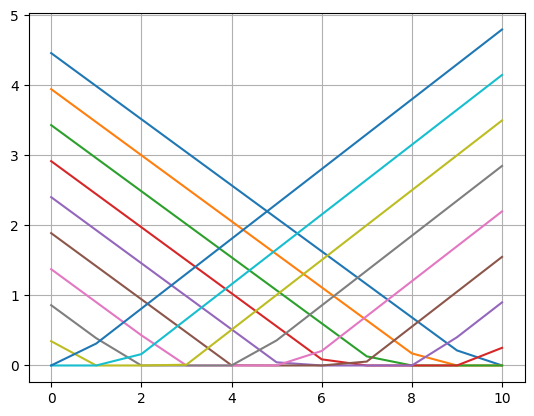

In [ ]:
xxx=np.zeros(11*11)
yyy=np.zeros(11*11)
VVV= np.zeros(11*11)

cnt=-1
for ii in range(11):
  for jj in range(11):
    cnt+=1
    V[ii,jj]=max(Q_cost_to_go_np(np.array([(ii-5)/10,(jj-5)/10 ])),0)
    VVV[cnt]=V[ii,jj]
    xxx[cnt] =(ii-5)/10
    yyy[cnt]= (jj-5)/10


plt.plot(V.T)
plt.grid()

In [ ]:
fig = go.Figure(data=[go.Scatter3d(    x=X_all_samples[:,0],    y=X_all_samples[:,1],    z=y_all_samples,    mode='markers',    marker=dict(size=5,color=VVV,        colorscale='Viridis',    opacity=0.8    ))])
fig2 = go.Figure(data=[go.Scatter3d(    x=xxx,    y=yyy,    z=VVV,    mode='markers',    marker=dict(size=5,color=VVV,        colorscale='Viridis',    opacity=0.8    ))])


In [ ]:
fig.show()
fig2.show()


In [ ]:
A_til=A_til*0

b_til=0*b_til

X_all_samples,y_all_samples,V=BENCHMARK_POINTS_GRID_MPC_EVAL(100)
V1=V.copy()
print((V.sum()))
A_til,b_til,dump_var=find_approx_q_with_Tropical_Division_random_Start(5)

X_all_samples,y_all_samples,V=BENCHMARK_POINTS_GRID_MPC_EVAL(100)
V2=V.copy()
A_til,b_til,dump_var=find_approx_q_with_Tropical_Division_random_Start(5)
print((V.sum()))

X_all_samples,y_all_samples,V=BENCHMARK_POINTS_GRID_MPC_EVAL(100)
V3=V.copy()
A_til,b_til,dump_var=find_approx_q_with_Tropical_Division_random_Start(5)
print((V.sum()))

X_all_samples,y_all_samples,V=BENCHMARK_POINTS_GRID_MPC_EVAL(100)
V4=V.copy()
A_til,b_til,dump_var=find_approx_q_with_Tropical_Division_random_Start(5)
print((V.sum()))


X_all_samples,y_all_samples,V=BENCHMARK_POINTS_GRID_MPC_EVAL(100)
V5=V.copy()
A_til,b_til,dump_var=find_approx_q_with_Tropical_Division_random_Start(5)
print((V.sum()))

X_all_samples,y_all_samples,V=BENCHMARK_POINTS_GRID_MPC_EVAL(100)
V6=V.copy()
A_til,b_til,dump_var=find_approx_q_with_Tropical_Division_random_Start(5)
print((V.sum()))



4655.856841037733


<ipython-input-86-12b58b5f9621>:26: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



4162.868743143764
4188.4430437904375
4499.455310068213
4119.028555313147
4138.802888275528


In [ ]:
A_of_q = np.random.randn(10,2)
b_of_q = np.random.randn(10)
for ii in range(150):
  I=np.argmax((X_all_samples@A_of_q.T+b_of_q),axis=1)
  J_i=np.array([(I==i).sum() for i in range(10)])
  b_of_q=b_of_q-J_i*0.01
b_of_q=b_of_q-b_of_q.mean()

a_q_i = cp.Variable(2)
b_q_i = cp.Variable(1)
for epan in range(15):
  I=np.argmax((X_all_samples@A_of_q.T+b_of_q),axis=1)
  J_i=np.array([(I==i).sum() for i in range(10)])
  for i in range(10):
    if J_i[i]==0:
      print("found")
      continue
    objective = cp.Maximize(cp.sum(X_all_samples[I==i]@a_q_i)+sum(I==i)*b_q_i)
    constraints= [X_all_samples[I==i]@a_q_i+b_q_i<=y_all_samples[I==i]]
    problem = cp.Problem(objective,constraints)
    problem.solve()
    A_of_q[i,:]=a_q_i.value
    b_of_q[i]=b_q_i.value
  VVV_est = np.max((X_all_samples@A_of_q.T+b_of_q),axis=1)


38

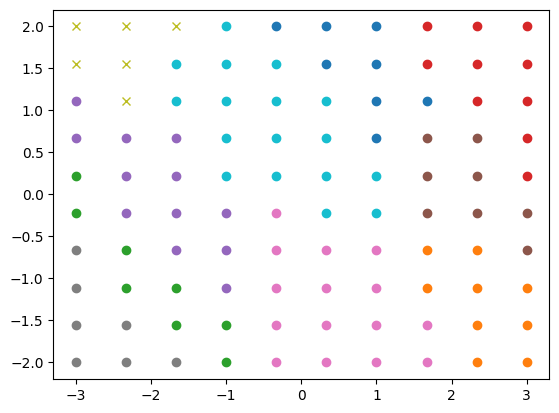

In [ ]:
plt.plot(X_all_samples[I==1][:,0],X_all_samples[I==1][:,1],'o')
plt.plot(X_all_samples[I==2][:,0],X_all_samples[I==2][:,1],'o')
plt.plot(X_all_samples[I==3][:,0],X_all_samples[I==3][:,1],'o')
plt.plot(X_all_samples[I==4][:,0],X_all_samples[I==4][:,1],'o')
plt.plot(X_all_samples[I==5][:,0],X_all_samples[I==5][:,1],'o')
plt.plot(X_all_samples[I==6][:,0],X_all_samples[I==6][:,1],'o')
plt.plot(X_all_samples[I==7][:,0],X_all_samples[I==7][:,1],'o')
plt.plot(X_all_samples[I==8][:,0],X_all_samples[I==8][:,1],'o')
plt.plot(X_all_samples[I==9][:,0],X_all_samples[I==9][:,1],'x')
plt.plot(X_all_samples[I==0][:,0],X_all_samples[I==0][:,1],'o')


In [ ]:
V_est=V*0
cnt=0
VV_est = np.max((X_all_samples@A_of_q.T+b_of_q),axis=1)
for ii in range(10):
  for jj in range(10):
    V_est[ii,jj]=VV_est[cnt]
    cnt+=1

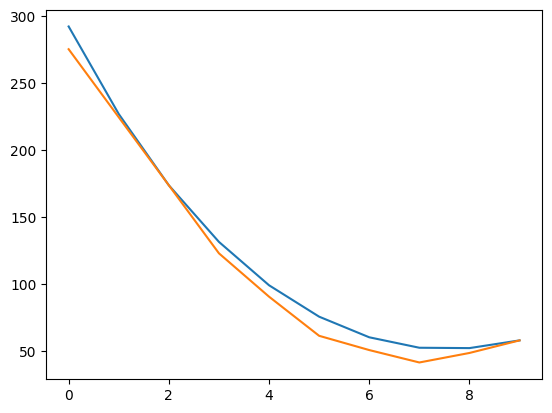

In [ ]:
plt.plot(V[0])
plt.plot(V_est[0])


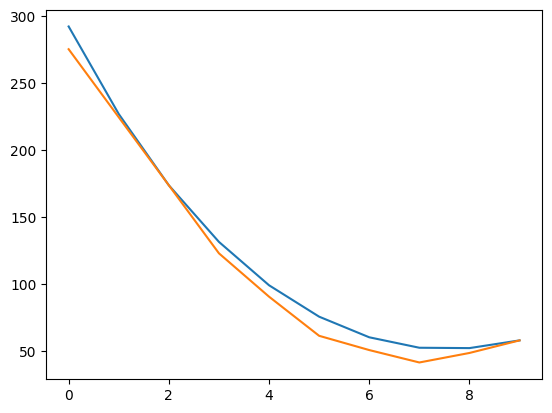

In [ ]:
plt.plot(V[0])
plt.plot(V_est[0])
